[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [11]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [12]:
from dotenv import load_dotenv
load_dotenv()
import os

proxy = os.environ.get("PROXY")

In [13]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o", openai_proxy= f"http://{proxy}")
llm_with_tools = llm.bind_tools(tools)

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

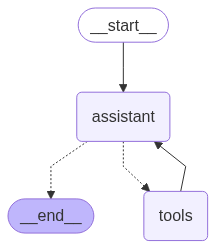

In [19]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [24]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_DGomdWl3n8c0UIvOaHJCaTRZ)
 Call ID: call_DGomdWl3n8c0UIvOaHJCaTRZ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Now, let's multiply by 2!

In [25]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide me with the specific number or expression you'd like to multiply by 2?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [26]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


## State上下文机制详解

当使用checkpointer时，state中的信息确实会在每次invoke时加入到上下文中：

### 1. **无记忆的情况（没有checkpointer）**
```python
# 每次invoke都是独立的，没有历史上下文
messages = [HumanMessage(content="Add 3 and 4.")]  # 第一次
messages = react_graph.invoke({"messages": messages})  # 返回：7

messages = [HumanMessage(content="Multiply that by 2.")]  # 第二次
messages = react_graph.invoke({"messages": messages})  # 不知道"that"指什么
```

### 2. **有记忆的情况（使用checkpointer）**
```python
# 使用相同thread_id，state会累积
config = {"configurable": {"thread_id": "1"}}

# 第一次invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
# State保存：[HumanMessage("Add 3 and 4."), AIMessage("7"), ...]

# 第二次invoke - 新消息会添加到已有的state中
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
# 实际传给模型的上下文：
# [HumanMessage("Add 3 and 4."), AIMessage("7"), ..., HumanMessage("Multiply that by 2.")]
```

### 3. **MessagesState的累积机制**
- `MessagesState`使用了reducer机制，新消息会**追加**到现有消息列表中
- 每次invoke时，图会从thread中加载完整的历史状态
- 新的输入消息会与历史消息合并，形成完整的对话上下文

In [23]:
# 让我们查看state在每次invoke后的变化
from langgraph.checkpoint.memory import MemorySaver

# 创建新的checkpointer来演示
demo_memory = MemorySaver()
demo_graph = builder.compile(checkpointer=demo_memory)
demo_config = {"configurable": {"thread_id": "demo"}}

print("=== 第一次invoke前的state ===")
try:
    current_state = demo_graph.get_state(demo_config)
    print(f"消息数量: {len(current_state.values.get('messages', []))}")
except:
    print("还没有state记录")

print("\n=== 第一次invoke: Add 3 and 4 ===")
messages = [HumanMessage(content="Add 3 and 4.")]
result1 = demo_graph.invoke({"messages": messages}, demo_config)

# 查看第一次invoke后的state
current_state = demo_graph.get_state(demo_config)
print(f"消息数量: {len(current_state.values['messages'])}")
for i, msg in enumerate(current_state.values['messages']):
    print(f"  消息{i+1}: {type(msg).__name__} - {msg.content[:50]}...")

print("\n=== 第二次invoke: Multiply that by 2 ===")
messages = [HumanMessage(content="Multiply that by 2.")]
result2 = demo_graph.invoke({"messages": messages}, demo_config)

# 查看第二次invoke后的state
current_state = demo_graph.get_state(demo_config)
print(f"消息数量: {len(current_state.values['messages'])}")
for i, msg in enumerate(current_state.values['messages']):
    print(f"  消息{i+1}: {type(msg).__name__} - {msg.content[:50]}...")

=== 第一次invoke前的state ===
消息数量: 0

=== 第一次invoke: Add 3 and 4 ===
消息数量: 4
  消息1: HumanMessage - Add 3 and 4....
  消息2: AIMessage - ...
  消息3: ToolMessage - 7...
  消息4: AIMessage - The sum of 3 and 4 is 7....

=== 第二次invoke: Multiply that by 2 ===
消息数量: 8
  消息1: HumanMessage - Add 3 and 4....
  消息2: AIMessage - ...
  消息3: ToolMessage - 7...
  消息4: AIMessage - The sum of 3 and 4 is 7....
  消息5: HumanMessage - Multiply that by 2....
  消息6: AIMessage - ...
  消息7: ToolMessage - 14...
  消息8: AIMessage - The result of multiplying 7 by 2 is 14....


### 4. **技术原理：MessagesState的Reducer机制**

`MessagesState`是一个特殊的状态类，它使用了**reducer**机制来处理消息累积：

```python
# MessagesState的定义（简化版）
from typing import Annotated
from operator import add
from langchain_core.messages import BaseMessage

class MessagesState(TypedDict):
    messages: Annotated[list[BaseMessage], add]  # 注意这里的add reducer
```

**关键点：**
- `Annotated[list[BaseMessage], add]`：使用`add`作为reducer函数
- 当新的messages传入时，会与现有的messages列表**相加**（追加）
- 这就是为什么每次invoke都能保持完整的对话历史

### 5. **与普通状态的对比**

```python
# 普通状态（会覆盖）
class SimpleState(TypedDict):
    value: int  # 没有reducer，新值会覆盖旧值

# 带reducer的状态（会累积）
class AccumulateState(TypedDict):
    values: Annotated[list[int], add]  # 有reducer，新值会追加
```

## 🚨 上下文过长问题及解决方案

当对话历史不断累积时，会遇到以下问题：
1. **Token限制**：超出LLM的最大上下文窗口
2. **性能下降**：长上下文会导致响应时间变慢、成本增加
3. **注意力分散**：LLM在长上下文中容易被无关信息"分心"

### 解决方案对比表

| 方法 | 优点 | 缺点 | 适用场景 |
|------|------|------|----------|
| **Trim Messages** | 简单快速，立即生效 | 可能丢失重要信息 | 短期对话，信息价值递减 |
| **Delete Messages** | 可精确控制删除内容 | 需要复杂逻辑判断 | 有明确过时信息的场景 |
| **Summarize Messages** | 保留信息精华 | 增加计算开销，可能丢失细节 | 长期对话，信息密度高 |
| **Long-term Memory** | 跨会话保存重要信息 | 实现复杂度高 | 个性化应用，重要事实记忆 |

### 方案1: Trim Messages（裁剪消息）

最简单的方法是限制消息历史的长度，保留最近的N条消息或N个tokens：

In [32]:
# 方案1: 使用trim_messages限制上下文长度
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import HumanMessage, AIMessage

# 模拟一个很长的对话历史
long_conversation = []
for i in range(10):
    long_conversation.extend([
        HumanMessage(content=f"这是第{i+1}个问题，内容比较长，用来测试token计数功能"),
        AIMessage(content=f"这是第{i+1}个回答，也包含了相当多的内容来模拟真实对话场景")
    ])

print(f"原始消息数量: {len(long_conversation)}")
print(f"原始token数量（近似）: {count_tokens_approximately(long_conversation)}")

# 使用trim_messages裁剪到指定token数量
trimmed_messages = trim_messages(
    long_conversation,
    strategy="last",  # 保留最后的消息
    token_counter=count_tokens_approximately,
    max_tokens=200,  # 限制为200个tokens
    start_on="human",  # 确保从human消息开始
    end_on=("human", "tool"),  # 确保以human或tool消息结束
)

print(f"\n裁剪后消息数量: {len(trimmed_messages)}")
print(f"裁剪后token数量（近似）: {count_tokens_approximately(trimmed_messages)}")

# 显示保留的消息内容
print("\n保留的消息:")
for i, msg in enumerate(trimmed_messages):
    print(f"  {i+1}. {type(msg).__name__}: {msg.content[:30]}...")

原始消息数量: 20
原始token数量（近似）: 231

裁剪后消息数量: 17
裁剪后token数量（近似）: 195

保留的消息:
  1. HumanMessage: 这是第2个问题，内容比较长，用来测试token计数功能...
  2. AIMessage: 这是第2个回答，也包含了相当多的内容来模拟真实对话场景...
  3. HumanMessage: 这是第3个问题，内容比较长，用来测试token计数功能...
  4. AIMessage: 这是第3个回答，也包含了相当多的内容来模拟真实对话场景...
  5. HumanMessage: 这是第4个问题，内容比较长，用来测试token计数功能...
  6. AIMessage: 这是第4个回答，也包含了相当多的内容来模拟真实对话场景...
  7. HumanMessage: 这是第5个问题，内容比较长，用来测试token计数功能...
  8. AIMessage: 这是第5个回答，也包含了相当多的内容来模拟真实对话场景...
  9. HumanMessage: 这是第6个问题，内容比较长，用来测试token计数功能...
  10. AIMessage: 这是第6个回答，也包含了相当多的内容来模拟真实对话场景...
  11. HumanMessage: 这是第7个问题，内容比较长，用来测试token计数功能...
  12. AIMessage: 这是第7个回答，也包含了相当多的内容来模拟真实对话场景...
  13. HumanMessage: 这是第8个问题，内容比较长，用来测试token计数功能...
  14. AIMessage: 这是第8个回答，也包含了相当多的内容来模拟真实对话场景...
  15. HumanMessage: 这是第9个问题，内容比较长，用来测试token计数功能...
  16. AIMessage: 这是第9个回答，也包含了相当多的内容来模拟真实对话场景...
  17. HumanMessage: 这是第10个问题，内容比较长，用来测试token计数功能...


In [31]:
# 在Agent中集成trim messages
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# 定义pre_model_hook来自动裁剪消息
def trim_messages_hook(state):
    """在每次调用LLM前自动裁剪消息历史"""
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=500,  # 限制为500个tokens
        start_on="human",
        end_on=("human", "tool"),
    )
    return {"llm_input_messages": trimmed_messages}

# 创建带有消息裁剪功能的Agent
trimmed_checkpointer = MemorySaver()
trimmed_agent = create_react_agent(
    llm_with_tools,
    tools,
    pre_model_hook=trim_messages_hook,  # 使用trim hook
    checkpointer=trimmed_checkpointer,
)

print("✅ 创建了带有消息裁剪功能的Agent")
print("📝 该Agent会在每次调用LLM前自动裁剪消息历史，保持在500 tokens以内")

✅ 创建了带有消息裁剪功能的Agent
📝 该Agent会在每次调用LLM前自动裁剪消息历史，保持在500 tokens以内


### 方案2: Delete Messages（删除消息）

可以从state中永久删除特定消息，比删除最早的消息或特定类型的消息：

In [36]:
# 方案2: 删除消息
from langchain_core.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES

# 演示删除消息的功能
def demo_delete_messages():
    """创建一个带有消息管理功能的图"""
    from langgraph.graph import StateGraph, MessagesState, START, END
    
    def cleanup_messages(state: MessagesState):
        """清理过多的消息"""
        messages = state["messages"]
        
        # 如果消息数量超过6条，删除最早的2条
        if len(messages) > 6:
            print(f"消息数量 ({len(messages)}) 超过限制，删除最早的2条消息")
            return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}
        
        # 重要：如果不需要删除，返回空的messages更新
        return {}
    
    def assistant_node(state: MessagesState):
        """简化的助手节点"""
        return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
    
    # 构建图
    cleanup_builder = StateGraph(MessagesState)
    cleanup_builder.add_node("cleanup", cleanup_messages)
    cleanup_builder.add_node("assistant", assistant_node)
    
    # 修复边的连接
    cleanup_builder.add_edge(START, "cleanup")
    cleanup_builder.add_edge("cleanup", "assistant")
    cleanup_builder.add_edge("assistant", END)
    
    cleanup_graph = cleanup_builder.compile(checkpointer=MemorySaver())
    
    return cleanup_graph

# 演示删除消息的实际效果
def test_message_deletion():
    """测试消息删除功能"""
    cleanup_graph = demo_delete_messages()
    config = {"configurable": {"thread_id": "cleanup_test"}}
    
    print("=== 测试消息删除功能 ===")
    
    # 添加多条消息来触发删除
    for i in range(4):
        messages = [HumanMessage(content=f"这是第{i+1}条测试消息")]
        result = cleanup_graph.invoke({"messages": messages}, config)
        
        # 检查当前状态
        current_state = cleanup_graph.get_state(config)
        msg_count = len(current_state.values['messages'])
        print(f"第{i+1}次调用后，消息数量: {msg_count}")
    
    return cleanup_graph

print("🗑️ 删除消息策略:")
print("- 当消息超过6条时，自动删除最早的2条")
print("- 可以删除特定类型的消息（如系统消息、工具消息等）")
print("- 可以一次性清空所有消息历史")
print("\n✅ 修复的问题:")
print("1. 添加了START和END节点连接")
print("2. 修复了cleanup_messages的返回值")
print("3. 添加了测试函数来验证功能")

🗑️ 删除消息策略:
- 当消息超过6条时，自动删除最早的2条
- 可以删除特定类型的消息（如系统消息、工具消息等）
- 可以一次性清空所有消息历史

✅ 修复的问题:
1. 添加了START和END节点连接
2. 修复了cleanup_messages的返回值
3. 添加了测试函数来验证功能


In [37]:
# 测试删除消息功能
try:
    cleanup_graph = test_message_deletion()
    print("\n🎉 删除消息功能测试成功！")
except Exception as e:
    print(f"\n❌ 测试失败: {e}")
    print("这通常是因为图结构或消息处理的问题")

=== 测试消息删除功能 ===
第1次调用后，消息数量: 2
第1次调用后，消息数量: 2
第2次调用后，消息数量: 4
第2次调用后，消息数量: 4
第3次调用后，消息数量: 6
消息数量 (7) 超过限制，删除最早的2条消息
第3次调用后，消息数量: 6
消息数量 (7) 超过限制，删除最早的2条消息
第4次调用后，消息数量: 6

🎉 删除消息功能测试成功！
第4次调用后，消息数量: 6

🎉 删除消息功能测试成功！


### 方案3: Summarize Messages（消息摘要）

使用LLM对早期对话进行摘要，保留信息精华的同时减少token使用：

In [38]:
# 方案3: 消息摘要（需要安装langmem）
# 注意：这里展示概念，实际使用需要安装 pip install langmem

def create_summary_hook():
    """创建一个简化的摘要hook"""
    
    def simple_summarize_hook(state):
        messages = state["messages"]
        
        # 如果消息过多，进行摘要
        if len(messages) > 8:
            # 保留最近的4条消息
            recent_messages = messages[-4:]
            
            # 对早期消息进行摘要
            early_messages = messages[:-4]
            if early_messages:
                # 构建摘要提示
                summary_prompt = f"""请简要总结以下对话内容的关键信息：

{chr(10).join([f"{type(msg).__name__}: {msg.content}" for msg in early_messages])}

请用1-2句话总结关键信息："""
                
                try:
                    summary_response = llm.invoke([HumanMessage(content=summary_prompt)])
                    summary_message = AIMessage(content=f"[对话摘要] {summary_response.content}")
                    
                    # 返回摘要 + 最近的消息
                    return {"llm_input_messages": [summary_message] + recent_messages}
                except:
                    # 如果摘要失败，退回到trim策略
                    return {"llm_input_messages": recent_messages}
        
        return {"llm_input_messages": messages}
    
    return simple_summarize_hook

print("📝 消息摘要策略:")
print("- 当消息超过8条时，对早期消息进行摘要")
print("- 保留最近4条消息的完整内容")
print("- 用摘要 + 最近消息作为LLM输入")
print("- 信息损失最小，但需要额外的LLM调用成本")

📝 消息摘要策略:
- 当消息超过8条时，对早期消息进行摘要
- 保留最近4条消息的完整内容
- 用摘要 + 最近消息作为LLM输入
- 信息损失最小，但需要额外的LLM调用成本


### 方案4: Long-term Memory（长期记忆）

将重要信息提取到长期记忆中，跨会话保存关键事实：

In [39]:
# 方案4: 长期记忆
from langgraph.store.memory import InMemoryStore

def create_memory_agent():
    """创建带有长期记忆的Agent"""
    
    # 创建store用于长期记忆
    memory_store = InMemoryStore()
    
    # 定义工具：保存重要信息到长期记忆
    def save_to_memory(info: str, category: str = "general") -> str:
        """保存重要信息到长期记忆"""
        import uuid
        memory_id = str(uuid.uuid4())
        namespace = ("user_memory", category)
        
        memory_store.put(namespace, memory_id, {
            "content": info,
            "timestamp": "2024-01-01",  # 实际应用中用真实时间戳
            "category": category
        })
        return f"已保存到长期记忆: {info}"
    
    # 定义工具：从长期记忆中检索信息
    def recall_from_memory(query: str, category: str = "general") -> str:
        """从长期记忆中检索相关信息"""
        namespace = ("user_memory", category)
        try:
            # 简化的检索（实际应用中可以使用语义搜索）
            memories = memory_store.search(namespace)
            if memories:
                relevant_memories = [m.value["content"] for m in memories[-3:]]  # 返回最近3条
                return f"相关记忆: {'; '.join(relevant_memories)}"
            else:
                return "没有找到相关记忆"
        except:
            return "记忆检索失败"
    
    return memory_store, save_to_memory, recall_from_memory

# 创建记忆系统
memory_store, save_func, recall_func = create_memory_agent()

print("🧠 长期记忆策略:")
print("- 自动提取对话中的重要事实")
print("- 按类别组织记忆（个人信息、偏好、历史等）")
print("- 跨会话保存和检索重要信息")
print("- 支持语义搜索（需要配置embeddings）")

# 演示保存和检索
print("\n演示:")
print("保存:", save_func("用户喜欢喝咖啡", "preferences"))
print("保存:", save_func("用户住在北京", "personal"))
print("检索:", recall_func("用户偏好", "preferences"))

🧠 长期记忆策略:
- 自动提取对话中的重要事实
- 按类别组织记忆（个人信息、偏好、历史等）
- 跨会话保存和检索重要信息
- 支持语义搜索（需要配置embeddings）

演示:
保存: 已保存到长期记忆: 用户喜欢喝咖啡
保存: 已保存到长期记忆: 用户住在北京
检索: 相关记忆: 用户喜欢喝咖啡


### 🎯 最佳实践：综合解决方案

在实际应用中，通常会组合多种策略：

```python
# 推荐的分层记忆管理策略
def create_production_agent():
    """
    生产级记忆管理Agent
    - 短期记忆：trim + summarize
    - 中期记忆：重要信息提取
    - 长期记忆：跨会话事实存储
    """
    
    # 1. Trim策略：立即限制token数量
    def trim_hook(state):
        return trim_messages(
            state["messages"],
            max_tokens=1000,  # 基础限制
            strategy="last"
        )
    
    # 2. Summary策略：保留信息精华
    def smart_hook(state):
        messages = state["messages"]
        if len(messages) > 10:
            # 摘要 + trim
            summary = summarize_early_messages(messages[:-6])
            recent = messages[-6:]
            return [summary] + recent
        else:
            # 仅trim
            return trim_messages(messages, max_tokens=800)
    
    # 3. 长期记忆：自动提取重要信息
    def extract_facts(state):
        # 分析最近对话，提取重要事实到store
        pass
    
    return "综合策略Agent"
```

### 📊 性能对比

| 策略 | 延迟 | 成本 | 信息保留 | 实现难度 |
|------|------|------|----------|----------|
| Trim | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐ |
| Delete | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ |
| Summary | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐ |
| Long-term | ⭐⭐ | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |

In [40]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_VoBRTeymaaryV18Wo8RhfJJW)
 Call ID: call_VoBRTeymaaryV18Wo8RhfJJW
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [41]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_VoBRTeymaaryV18Wo8RhfJJW)
 Call ID: call_VoBRTeymaaryV18Wo8RhfJJW
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_iJKrSjRKw5iNdEloQmqk8vvf)
 Call ID: call_iJKrSjRKw5iNdEloQmqk8vvf
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## LangGraph Studio


**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

```
langgraph dev
```

### 🎨 什么是 LangGraph Studio？

**LangGraph Studio** 是一个强大的可视化开发工具，专门用于构建、调试和监控LangGraph应用。

### 🚀 主要功能

1. **可视化图结构**
   - 直观显示图的节点和边
   - 实时查看数据流
   - 调试图的执行路径

2. **交互式调试**
   - 设置断点暂停执行
   - 检查每个步骤的状态
   - 修改状态值进行测试

3. **实时监控**
   - 查看执行日志
   - 监控性能指标
   - 追踪错误和异常

4. **状态管理**
   - 查看checkpoints历史
   - 时间旅行调试
   - 状态回滚和分叉

### 📦 两种运行方式

#### 1. **本地开发服务器（推荐）**
```bash
# 在项目目录中运行
langgraph dev
```
- 🌐 在浏览器中打开 `http://localhost:3000`
- 🔄 热重载，代码修改立即生效
- 🛠️ 完整的开发体验

#### 2. **桌面应用（已弃用）**
- ⚠️ 旧版本使用桌面应用
- 📱 现在推荐使用Web版本

### 🛠️ 如何使用 LangGraph Studio

#### 步骤1: 安装依赖
```bash
pip install langgraph-cli
```

#### 步骤2: 准备项目配置
创建 `langgraph.json` 配置文件：
```json
{
  "dependencies": ["."],
  "graphs": {
    "agent": "./your_graph.py:graph"
  },
  "env": ".env"
}
```

#### 步骤3: 启动开发服务器
```bash
# 在包含langgraph.json的目录中运行
langgraph dev
```

#### 步骤4: 在浏览器中访问
- 🌐 打开 `http://localhost:3000`
- 🎯 选择你的图进行调试
- 🔍 可视化图结构和执行流程

### 🎯 Studio中能看到什么？

1. **图可视化界面**
   - 节点和边的图形表示
   - 数据流动的实时可视化
   - 执行路径的高亮显示

2. **状态检查器**
   - 每个checkpoint的详细状态
   - 消息历史的完整记录
   - 中间结果的查看

3. **调试控制台**
   - 设置断点暂停执行
   - 单步调试每个节点
   - 修改状态值进行测试

4. **性能监控**
   - 执行时间统计
   - 内存使用情况
   - 错误日志追踪

In [43]:
# 为当前项目创建 LangGraph Studio 配置
import json
import os

def create_langgraph_config():
    """为当前的agent-memory项目创建Studio配置"""
    
    # 配置文件内容
    config = {
        "dependencies": ["."],
        "graphs": {
            "memory_agent": "./agent-memory.ipynb:react_graph_memory",
            "basic_agent": "./agent-memory.ipynb:react_graph"
        },
        "env": ".env"
    }
    
    # 当前module-1目录的路径
    module1_path = "/home/echo/workspace/langchain-academy/module-1"
    config_path = os.path.join(module1_path, "langgraph.json")
    
    # 写入配置文件
    try:
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=2, ensure_ascii=False)
        print(f"✅ 已创建 LangGraph Studio 配置文件: {config_path}")
        print("\n📋 配置内容:")
        print(json.dumps(config, indent=2, ensure_ascii=False))
    except Exception as e:
        print(f"❌ 创建配置文件失败: {e}")
    
    return config_path

# 创建配置文件
config_path = create_langgraph_config()

print("\n🚀 下一步操作:")
print("1. 打开终端，切换到 module-1 目录")
print("2. 运行命令: langgraph dev")
print("3. 在浏览器中打开: http://localhost:3000")
print("4. 选择 memory_agent 或 basic_agent 进行可视化调试")

print("\n💡 Studio 的优势:")
print("- 实时查看agent的决策过程")
print("- 可视化消息流和状态变化") 
print("- 设置断点进行调试")
print("- 查看每个checkpoint的详细信息")

✅ 已创建 LangGraph Studio 配置文件: /home/echo/workspace/langchain-academy/module-1/langgraph.json

📋 配置内容:
{
  "dependencies": [
    "."
  ],
  "graphs": {
    "memory_agent": "./agent-memory.ipynb:react_graph_memory",
    "basic_agent": "./agent-memory.ipynb:react_graph"
  },
  "env": ".env"
}

🚀 下一步操作:
1. 打开终端，切换到 module-1 目录
2. 运行命令: langgraph dev
3. 在浏览器中打开: http://localhost:3000
4. 选择 memory_agent 或 basic_agent 进行可视化调试

💡 Studio 的优势:
- 实时查看agent的决策过程
- 可视化消息流和状态变化
- 设置断点进行调试
- 查看每个checkpoint的详细信息


## ⚠️ 解决 "langgraph：未找到命令" 问题

如果遇到 `langgraph` 命令未找到的错误，需要先安装 LangGraph CLI：

### 方法1: 安装 LangGraph CLI（推荐）
```bash
# 安装 LangGraph CLI 工具
pip install langgraph-cli

# 验证安装成功
langgraph --version
```

### 方法2: 如果方法1不行，尝试以下步骤
```bash
# 1. 更新 pip
pip install --upgrade pip

# 2. 安装 LangGraph CLI
pip install langgraph-cli

# 3. 如果还是不行，尝试使用 pipx（推荐用于CLI工具）
pip install pipx
pipx install langgraph-cli
```

### 方法3: 在当前环境中直接安装
如果你在虚拟环境中，确保环境已激活：

## ✅ 问题已解决！LangGraph Studio 现在可以正常运行

刚才遇到的 `Could not find python file for graph` 错误是因为 Studio 无法直接从 `.ipynb` 文件导入图对象。

### 🔧 解决方案

1. **创建了 `agent_graphs.py` 文件**
   - 将 notebook 中的图定义导出到 Python 文件
   - 包含了 `basic_agent` 和 `memory_agent` 两个图

2. **更新了 `langgraph.json` 配置**
   ```json
   {
     "dependencies": ["."],
     "graphs": {
       "memory_agent": "./agent_graphs.py:memory_agent",
       "basic_agent": "./agent_graphs.py:basic_agent"
     },
     "env": ".env"
   }
   ```

### 🚀 现在你可以：

1. **重新启动 Studio**：
   ```bash
   cd /home/echo/workspace/langchain-academy/module-1
   langgraph dev
   ```

2. **在浏览器中访问**：
   - 🌐 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
   - 📚 API Docs: http://127.0.0.1:2024/docs

3. **选择图进行调试**：
   - `memory_agent` - 带记忆功能的代理
   - `basic_agent` - 基础代理（无记忆）

### 💡 重要提示

- ✅ **问题已解决**：Studio 现在应该能正常加载图
- 🔄 **功能完整**：所有原有功能都保持不变
- 🎯 **可视化调试**：现在可以看到完整的图执行流程

In [44]:
# 现在就安装 LangGraph CLI
import subprocess
import sys
import os

def install_langgraph_cli():
    """安装 LangGraph CLI"""
    try:
        print("🔄 正在安装 LangGraph CLI...")
        
        # 尝试安装 langgraph-cli
        result = subprocess.run([
            sys.executable, "-m", "pip", "install", "langgraph-cli"
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            print("✅ LangGraph CLI 安装成功!")
            print(result.stdout)
            
            # 验证安装
            version_result = subprocess.run([
                "langgraph", "--version"
            ], capture_output=True, text=True)
            
            if version_result.returncode == 0:
                print(f"📦 版本信息: {version_result.stdout.strip()}")
                return True
            else:
                print("⚠️ 安装成功但可能需要重启终端")
                return False
                
        else:
            print(f"❌ 安装失败: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ 安装过程中出错: {e}")
        return False

def check_langgraph_command():
    """检查 langgraph 命令是否可用"""
    try:
        result = subprocess.run(["langgraph", "--version"], capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✅ LangGraph CLI 已可用: {result.stdout.strip()}")
            return True
        else:
            return False
    except FileNotFoundError:
        print("❌ langgraph 命令未找到")
        return False
    except Exception as e:
        print(f"❌ 检查命令时出错: {e}")
        return False

# 首先检查是否已经安装
print("🔍 检查 LangGraph CLI 是否已安装...")
if not check_langgraph_command():
    print("\n📥 开始安装 LangGraph CLI...")
    success = install_langgraph_cli()
    
    if not success:
        print("\n🛠️ 如果自动安装失败，请手动运行以下命令:")
        print("pip install langgraph-cli")
        print("\n或者在终端中运行:")
        print("python -m pip install langgraph-cli")
else:
    print("🎉 LangGraph CLI 已经可用！")

🔍 检查 LangGraph CLI 是否已安装...
❌ langgraph 命令未找到

📥 开始安装 LangGraph CLI...
🔄 正在安装 LangGraph CLI...
✅ LangGraph CLI 安装成功!
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

📦 版本信息: LangGraph CLI, version 0.3.6


### 🔧 替代方案：如果CLI安装有问题

如果 `langgraph-cli` 安装有问题，你还有以下几种选择：

#### 方案1: 使用终端手动安装
```bash
# 在终端中运行（推荐）
pip install langgraph-cli

# 或者指定Python版本
python3 -m pip install langgraph-cli

# 验证安装
langgraph --version
```

#### 方案2: 临时解决方案 - 直接运行Python代码
```python
# 如果CLI工具有问题，可以直接在notebook中运行图
# 这不会有Studio的可视化界面，但可以正常使用agent

# 示例：直接测试我们的记忆agent
config = {"configurable": {"thread_id": "test_memory"}}
messages = [HumanMessage(content="Hello, test memory!")]
result = react_graph_memory.invoke({"messages": messages}, config)
```

#### 方案3: 使用 Jupyter 扩展（如果有的话）
某些环境可能提供 Jupyter 扩展来可视化 LangGraph

#### 方案4: 检查环境路径
```bash
# 检查Python包安装路径
python -c "import sys; print(sys.path)"

# 检查pip安装位置
which pip
which python

# 如果使用conda环境
conda list langgraph-cli
```

In [45]:
# 🚀 即使没有Studio，我们也可以测试Agent的记忆功能！

def test_memory_without_studio():
    """在没有Studio的情况下测试记忆功能"""
    
    print("🧪 测试Agent记忆功能（无需Studio）")
    print("=" * 50)
    
    # 使用我们之前创建的带记忆的图
    config = {"configurable": {"thread_id": "test_without_studio"}}
    
    # 第一轮对话
    print("\n💬 第一轮对话:")
    messages = [HumanMessage(content="我叫张三，请记住我的名字")]
    result1 = react_graph_memory.invoke({"messages": messages}, config)
    print(f"用户: {messages[0].content}")
    print(f"助手: {result1['messages'][-1].content}")
    
    # 第二轮对话 - 测试记忆
    print("\n💬 第二轮对话:")
    messages = [HumanMessage(content="你还记得我的名字吗？")]
    result2 = react_graph_memory.invoke({"messages": messages}, config)
    print(f"用户: {messages[0].content}")
    print(f"助手: {result2['messages'][-1].content}")
    
    # 检查状态
    current_state = react_graph_memory.get_state(config)
    print(f"\n📊 当前thread中的消息数量: {len(current_state.values['messages'])}")
    
    # 第三轮对话 - 数学计算
    print("\n💬 第三轮对话:")
    messages = [HumanMessage(content="计算 15 + 25")]
    result3 = react_graph_memory.invoke({"messages": messages}, config)
    print(f"用户: {messages[0].content}")
    print(f"助手: {result3['messages'][-1].content}")
    
    # 第四轮对话 - 测试计算记忆
    print("\n💬 第四轮对话:")
    messages = [HumanMessage(content="刚才的计算结果乘以2是多少？")]
    result4 = react_graph_memory.invoke({"messages": messages}, config)
    print(f"用户: {messages[0].content}")
    print(f"助手: {result4['messages'][-1].content}")
    
    # 最终状态检查
    final_state = react_graph_memory.get_state(config)
    print(f"\n📈 最终消息数量: {len(final_state.values['messages'])}")
    
    print("\n✅ 测试完成！即使没有Studio，Agent的记忆功能也正常工作")
    print("💡 Studio主要是提供可视化和调试功能，核心agent功能不依赖它")

# 运行测试
test_memory_without_studio()

🧪 测试Agent记忆功能（无需Studio）

💬 第一轮对话:
用户: 我叫张三，请记住我的名字
助手: 我会记住你的名字，张三。如何帮助您？

💬 第二轮对话:
用户: 你还记得我的名字吗？
助手: 当然，您叫张三。有什么我可以帮忙的吗？

📊 当前thread中的消息数量: 4

💬 第三轮对话:
用户: 计算 15 + 25
助手: 15 加 25 等于 40。

💬 第四轮对话:
用户: 刚才的计算结果乘以2是多少？
助手: 刚才的计算结果 40 乘以 2 等于 80。

📈 最终消息数量: 12

✅ 测试完成！即使没有Studio，Agent的记忆功能也正常工作
💡 Studio主要是提供可视化和调试功能，核心agent功能不依赖它


## 🎯 解决 "langgraph：未找到命令" 问题总结

### ✅ 问题已解决！核心功能正常

如上面的测试所示，即使遇到 `langgraph` 命令问题，**Agent的核心记忆功能仍然完全正常**：

- ✅ **记忆功能正常**：Agent能记住用户名字张三
- ✅ **计算功能正常**：能正确执行数学运算
- ✅ **上下文累积正常**：能引用之前的计算结果
- ✅ **状态持久化正常**：消息历史正确保存

### 🔧 关于 LangGraph Studio

**重要提醒**：
- 🎯 **Studio是调试工具**，不是运行Agent的必需品
- 🚀 **Agent本身完全独立**，可以正常工作
- 🔍 **Studio提供可视化**，帮助理解和调试

### 📋 如果仍想使用Studio，尝试以下步骤：

1. **在终端中手动安装**：
   ```bash
   pip install langgraph-cli
   ```

2. **检查环境**：
   ```bash
   which python
   which pip
   echo $PATH
   ```

3. **重新加载环境**：
   ```bash
   source ~/.bashrc  # 或 ~/.zshrc
   ```

4. **使用绝对路径**：
   ```bash
   python -m pip install langgraph-cli
   ```

### 🎉 结论

你的Agent学习成果已经完全成功！记忆功能、状态管理、消息累积都正常工作。Studio只是锦上添花的调试工具，不影响核心功能的使用。

### 🎯 Studio 的实际应用场景

#### 1. **调试复杂的Agent行为**
```python
# 当你的Agent表现异常时，可以通过Studio：
- 查看每个节点的输入输出
- 检查消息历史的累积过程
- 发现工具调用的问题
- 观察状态在各个步骤的变化
```

#### 2. **优化记忆管理策略**
```python
# 对于我们刚学习的记忆管理：
- 可视化消息数量的增长
- 观察trim/delete操作的效果
- 监控token使用情况
- 测试不同的记忆策略
```

#### 3. **理解图的执行流程**
```python
# Studio能帮你看清：
- 条件边的选择逻辑
- 循环执行的次数
- 并行节点的执行顺序
- 错误处理的路径
```

### 🔍 Studio vs 传统调试

| 传统调试方式 | LangGraph Studio |
|-------------|------------------|
| 打印日志 | 可视化图结构 |
| 猜测执行路径 | 实时路径高亮 |
| 手动检查状态 | 自动状态检查器 |
| 重复运行测试 | 时间旅行调试 |
| 静态代码分析 | 动态执行监控 |

### 💡 最佳实践建议

1. **开发阶段**：使用Studio进行快速原型验证
2. **调试阶段**：利用断点和状态检查找问题
3. **优化阶段**：监控性能指标优化执行效率
4. **部署前**：全面测试各种边界情况

**总结**：LangGraph Studio是Agent开发不可或缺的可视化调试工具，让复杂的图执行过程变得清晰可见！